# input

In [ ]:
# =============================================================================
#                   KONFIGURASI PENGGUNA (EDIT DI SINI)
# =============================================================================

# Pilih Mode: 'single' atau 'folder'
MODE = "folder"

# Path File (untuk single)
FILE_PATH = r"test/image1.jpg"

# Path Folder (untuk folder) - Bisa satu folder atau list folder
# Contoh single: r"C:\Data_Penelitian\Citra_XRAY"
# Contoh multiple: [r"C:\Folder1", r"C:\Folder2", r"C:\Folder3"]
FOLDER_PATH = r"test"

# code

Running Batch Mode...
[INFO] Ditemukan 48 file di: E:\rsa-lenovo\pacs

[SUMMARY] Total file: 48, Unik: 48, Duplikat: 0
Memproses 48 file secara batch...

[WARNING] Background extremely uniform (std≈0). Using estimated noise: 109.1803
[WARNING] Background extremely uniform (std≈0). Using estimated noise: 102.6211
[WARNING] Background extremely uniform (std≈0). Using estimated noise: 106.3423
[WARNING] Background extremely uniform (std≈0). Using estimated noise: 120.0078
[WARNING] Background extremely uniform (std≈0). Using estimated noise: 117.5667
[WARNING] Background extremely uniform (std≈0). Using estimated noise: 121.3714
[WARNING] No edges passed strict validation. Using fallback edge.
[WARNING] Background extremely uniform (std≈0). Using estimated noise: 111.1175
[WARNING] Background extremely uniform (std≈0). Using estimated noise: 103.8735
[WARNING] Background extremely uniform (std≈0). Using estimated noise: 100.1410
[WARNING] Background extremely uniform (std≈0). Using estima

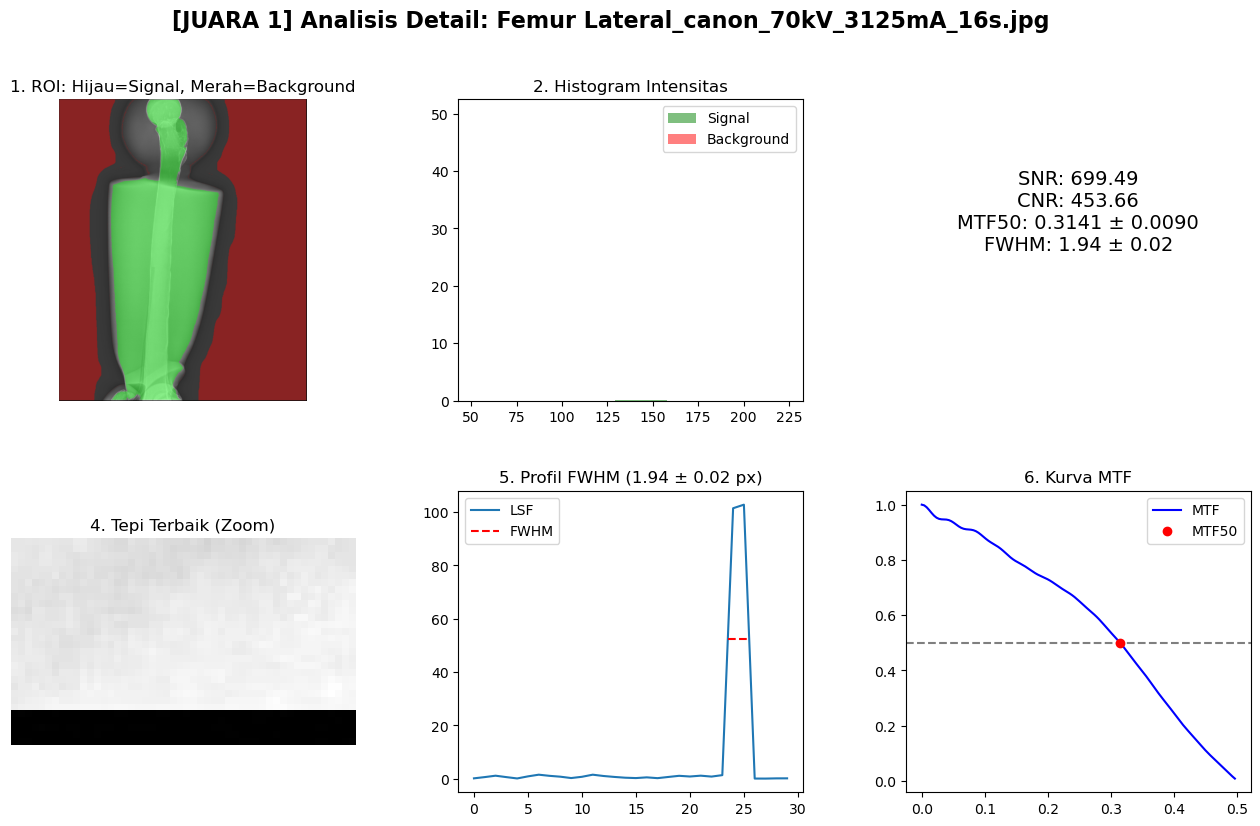

In [10]:
# =============================================================================
#                          KODE PROGRAM
# =============================================================================

import os
import glob
import numpy as np
import pandas as pd
import tifffile
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import UnivariateSpline, interp1d
from skimage import filters
from collections import OrderedDict


class XRayAnalyzer:
    def __init__(self):
        self._processed_files = set()  # Track processed files to avoid duplicates

    def load_image(self, filepath):
        if not os.path.exists(filepath):
            return None
        try:
            # Try OpenCV first (handles JPG, PNG, BMP, and most TIFF)
            img = cv2.imread(filepath, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE)
            
            # If OpenCV fails, try tifffile (for special TIFF formats)
            if img is None:
                img = tifffile.imread(filepath)
            
            # Convert to grayscale if multi-channel
            if img.ndim > 2:
                img = img[:, :, 0]
            
            return img.astype(np.float64)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None

    # -------------------------------------------------------------------------
    # CORE LOGIC (OTAK UTAMA)
    # -------------------------------------------------------------------------
    def _analyze_core(self, filepath):
        img = self.load_image(filepath)
        if img is None:
            return None

        # 1. ROI Detection & Hole Filling
        img_8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        try:
            thresh = filters.threshold_otsu(img_8bit)
            mask_raw = img_8bit > thresh
        except:
            mask_raw = np.zeros_like(img_8bit, dtype=bool)
            h, w = img.shape
            mask_raw[h // 3 : 2 * h // 3, w // 3 : 2 * w // 3] = True

        # Hole Filling
        mask_filled = ndimage.binary_fill_holes(mask_raw)

        kernel = np.ones((5, 5), np.uint8)
        mask_sig = cv2.erode(mask_filled.astype(np.uint8), kernel, iterations=3).astype(
            bool
        )

        mask_bg_raw = (~mask_filled).astype(np.uint8)
        mask_bg = cv2.erode(mask_bg_raw, kernel, iterations=5)

        # Filter Background - remove outliers
        bg_vals = img[mask_bg == 1]
        if len(bg_vals) > 0:
            # Use IQR method for robust outlier removal
            q1, q3 = np.percentile(bg_vals, [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            mask_bg = (mask_bg == 1) & (img >= lower_bound) & (img <= upper_bound)
            if np.sum(mask_bg) < 100:
                # Fallback to percentile method
                limit = np.percentile(bg_vals, 80)
                mask_bg = (mask_bg_raw == 1) & (img < limit)
                if np.sum(mask_bg) < 100:
                    mask_bg = mask_bg_raw == 1
        else:
            mask_bg = mask_bg == 1

        sig_pixels = img[mask_sig]
        bg_pixels = img[mask_bg]

        if len(sig_pixels) == 0 or len(bg_pixels) == 0:
            return None

        mean_sig = np.mean(sig_pixels)
        std_sig = np.std(sig_pixels)
        mean_bg = np.mean(bg_pixels)
        std_bg = np.std(bg_pixels)
        
        # IMPROVED: Better handling for low-noise backgrounds
        # Set minimum std_bg to prevent unrealistic SNR/CNR values
        # This threshold is based on typical X-ray imaging noise levels
        MIN_STD_BG = 0.1  # Minimum 0.1 intensity units
        
        # For very uniform backgrounds, use signal std as reference
        if std_bg < MIN_STD_BG:
            # If background is extremely uniform, estimate noise from signal region
            if std_bg < 1e-9:
                std_bg = max(MIN_STD_BG, std_sig * 0.01)  # Use 1% of signal std as minimum
                print(f"[WARNING] Background extremely uniform (std≈0). Using estimated noise: {std_bg:.4f}")
            else:
                std_bg = max(MIN_STD_BG, std_bg)
                print(f"[WARNING] Background std very low ({std_bg:.4f}). Using minimum threshold: {MIN_STD_BG}")

        # SNR: Signal-to-Noise Ratio
        # Definition: Mean of signal region / Standard deviation of background
        snr = mean_sig / std_bg

        # CNR: Contrast-to-Noise Ratio  
        # Definition: |Mean_signal - Mean_background| / Std_background
        cnr = np.abs(mean_sig - mean_bg) / std_bg

        # 2. Sharpness Analysis with detailed debugging
        fwhm, mtf50, fwhm_std, mtf50_std, all_fwhm, all_mtf50, sharp_debug = self._calc_sharpness(img)

        return {
            "filename": os.path.basename(filepath),
            "filepath": filepath,
            "img": img,
            "mask_sig": mask_sig,
            "mask_bg": mask_bg,
            "snr": snr,
            "cnr": cnr,
            "fwhm": fwhm,
            "mtf50": mtf50,
            "fwhm_std": fwhm_std,
            "mtf50_std": mtf50_std,
            "all_fwhm": all_fwhm,
            "all_mtf50": all_mtf50,
            "mean_sig": mean_sig,
            "std_sig": std_sig,
            "mean_bg": mean_bg,
            "std_bg": std_bg,
            "n_sig_pixels": len(sig_pixels),
            "n_bg_pixels": len(bg_pixels),
            "sharp_debug": sharp_debug,
        }

    def _calc_sharpness(self, img, n_edges=5, min_edge_distance=50):
        """
        Calculate sharpness metrics using MULTI-EDGE AVERAGING for more reliable results.
        
        Process:
        1. Find multiple strong edges in the image (not just the strongest)
        2. For each valid edge, calculate FWHM and MTF
        3. Select the BEST value (min FWHM, max MTF50) for sharpest measurement
        4. Calculate standard deviation for precision assessment
        5. GUARANTEE at least 1 edge is used (fallback to best candidate)
        
        Args:
            img: Input image
            n_edges: Number of edges to analyze (default: 5)
            min_edge_distance: Minimum distance between edges in pixels (default: 50)
        
        Returns:
            fwhm: Best (minimum) FWHM value
            mtf50: Best (maximum) MTF50 value
            fwhm_std: Standard deviation of all FWHM measurements
            mtf50_std: Standard deviation of all MTF50 measurements
            all_fwhm: List of all valid FWHM values
            all_mtf50: List of all valid MTF50 values
            debug_data: Debug information for visualization
        """
        # Step 1: Find multiple strong edge locations using Sobel
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
        grad = np.sqrt(sobelx**2 + sobely**2)
        
        # Find multiple edge candidates using non-maximum suppression
        edge_candidates = self._find_multiple_edges(grad, n_edges * 3, min_edge_distance)
        
        debug_data = {
            "roi": None,
            "edge_location": None,
            "edge_angle": None,
            "esf": None,
            "lsf": None,
            "lsf_smooth": None,
            "mtf": None,
            "mtf_freqs": None,
            "roots": None,
            "fwhm_detail": None,
            "mtf50_detail": None,
            "valid": False,
            "multi_edge": {
                "n_edges_found": 0,
                "n_edges_valid": 0,
                "all_fwhm": [],
                "all_mtf50": [],
                "edge_locations": [],
                "rejected_edges": [],
            }
        }
        
        # Step 2: Analyze each edge candidate
        valid_fwhms = []
        valid_mtf50s = []
        valid_edges_data = []
        best_fwhm_edge_data = None
        best_mtf50_edge_data = None
        best_fwhm_value = float('inf')
        best_mtf50_value = 0
        
        # FALLBACK: Keep track of best candidate even if it fails validation
        # AGGRESSIVE: Keep ANY result, even if quality is poor
        fallback_edge = None
        fallback_fwhm = None
        fallback_mtf50 = None
        
        for i, (x, y, grad_val) in enumerate(edge_candidates):
            edge_result = self._analyze_single_edge(img, x, y, sobelx, sobely)
            
            if edge_result is not None:
                fwhm_i, mtf50_i, edge_data = edge_result
                
                # AGGRESSIVE FALLBACK: Keep first ANY result, even if values are 0
                # This ensures we ALWAYS have at least 1 edge
                if fallback_edge is None:
                    fallback_edge = edge_data
                    fallback_fwhm = max(fwhm_i, 0.1)  # Use minimum value if 0
                    fallback_mtf50 = max(mtf50_i, 0.001)  # Use minimum value if 0
                
                # Validate the edge measurement
                if self._validate_edge_measurement(fwhm_i, mtf50_i, edge_data):
                    valid_fwhms.append(fwhm_i)
                    valid_mtf50s.append(mtf50_i)
                    valid_edges_data.append({
                        "location": (x, y),
                        "fwhm": fwhm_i,
                        "mtf50": mtf50_i,
                        "grad_strength": grad_val
                    })
                    debug_data["multi_edge"]["edge_locations"].append((x, y))
                    
                    # Track best FWHM (minimum = sharpest)
                    if fwhm_i < best_fwhm_value:
                        best_fwhm_value = fwhm_i
                        best_fwhm_edge_data = edge_data
                    
                    # Track best MTF50 (maximum = sharpest)
                    if mtf50_i > best_mtf50_value:
                        best_mtf50_value = mtf50_i
                        best_mtf50_edge_data = edge_data
                else:
                    debug_data["multi_edge"]["rejected_edges"].append({
                        "location": (x, y),
                        "reason": "failed validation",
                        "fwhm": fwhm_i,
                        "mtf50": mtf50_i
                    })
            
            # Stop if we have enough valid edges
            if len(valid_fwhms) >= n_edges:
                break
        
        debug_data["multi_edge"]["n_edges_found"] = len(edge_candidates)
        debug_data["multi_edge"]["n_edges_valid"] = len(valid_fwhms)
        debug_data["multi_edge"]["all_fwhm"] = valid_fwhms
        debug_data["multi_edge"]["all_mtf50"] = valid_mtf50s
        
        # Step 3: Calculate final metrics using BEST values (not median)
        # IMPORTANT: Use fallback if no valid edges found
        if len(valid_fwhms) >= 1:
            # Use BEST values: min FWHM (sharpest), max MTF50 (sharpest)
            fwhm = min(valid_fwhms)  # Lower FWHM = sharper
            mtf50 = max(valid_mtf50s)  # Higher MTF50 = sharper
            
            # Calculate standard deviation for precision assessment
            fwhm_std = np.std(valid_fwhms) if len(valid_fwhms) > 1 else 0
            mtf50_std = np.std(valid_mtf50s) if len(valid_mtf50s) > 1 else 0
            
            # Use best FWHM edge for visualization (since FWHM is primary sharpness metric)
            best_edge_data = best_fwhm_edge_data
            
            debug_data["valid"] = True
            debug_data["fwhm_detail"] = {
                "method": "best (minimum)",
                "n_edges_used": len(valid_fwhms),
                "all_values": valid_fwhms,
                "std_dev": fwhm_std,
                "best_value": fwhm,
                "median_value": np.median(valid_fwhms),
                "mean_value": np.mean(valid_fwhms),
            }
            debug_data["mtf50_detail"] = {
                "method": "best (maximum)",
                "n_edges_used": len(valid_mtf50s),
                "all_values": valid_mtf50s,
                "std_dev": mtf50_std,
                "best_value": mtf50,
                "median_value": np.median(valid_mtf50s),
                "mean_value": np.mean(valid_mtf50s),
            }
            
            # Set debug visualization data from best edge
            if best_edge_data:
                debug_data["roi"] = best_edge_data["roi"]
                debug_data["edge_location"] = best_edge_data.get("location", None)
                debug_data["edge_angle"] = best_edge_data.get("edge_angle")
                debug_data["esf"] = best_edge_data.get("esf")
                debug_data["lsf"] = best_edge_data.get("lsf")
                debug_data["lsf_smooth"] = best_edge_data.get("lsf_smooth")
                debug_data["profile_direction"] = best_edge_data.get("profile_direction")
                debug_data["roots"] = best_edge_data.get("roots")
            
            # Calculate MTF curve from best MTF edge for visualization
            if best_mtf50_edge_data and best_mtf50_edge_data.get("lsf_smooth") is not None:
                lsf_smooth = best_mtf50_edge_data["lsf_smooth"]
                n_pad = max(256, 2 ** int(np.ceil(np.log2(len(lsf_smooth) * 4))))
                lsf_padded = np.zeros(n_pad)
                start_idx = (n_pad - len(lsf_smooth)) // 2
                lsf_padded[start_idx:start_idx + len(lsf_smooth)] = lsf_smooth
                
                mtf_full = np.abs(np.fft.fft(lsf_padded))
                mtf_curve = mtf_full[: n_pad // 2]
                mtf_curve = mtf_curve / (mtf_curve[0] + 1e-9)
                freqs = np.fft.fftfreq(n_pad)[:n_pad // 2]
                
                debug_data["mtf"] = mtf_curve
                debug_data["mtf_freqs"] = freqs
        elif fallback_edge is not None:
            # FALLBACK: No edges passed validation, use best candidate anyway
            print(f"[WARNING] No edges passed strict validation. Using fallback edge.")
            fwhm = fallback_fwhm
            mtf50 = fallback_mtf50
            fwhm_std = 0
            mtf50_std = 0
            valid_fwhms = [fallback_fwhm]
            valid_mtf50s = [fallback_mtf50]
            
            debug_data["valid"] = True
            debug_data["fwhm_detail"] = {
                "method": "fallback (only candidate)",
                "n_edges_used": 1,
                "all_values": [fallback_fwhm],
                "std_dev": 0,
                "best_value": fallback_fwhm,
                "median_value": fallback_fwhm,
                "mean_value": fallback_fwhm,
            }
            debug_data["mtf50_detail"] = {
                "method": "fallback (only candidate)",
                "n_edges_used": 1,
                "all_values": [fallback_mtf50],
                "std_dev": 0,
                "best_value": fallback_mtf50,
                "median_value": fallback_mtf50,
                "mean_value": fallback_mtf50,
            }
            
            # Set debug visualization data from fallback edge
            debug_data["roi"] = fallback_edge["roi"]
            debug_data["edge_location"] = fallback_edge.get("location", None)
            debug_data["edge_angle"] = fallback_edge.get("edge_angle")
            debug_data["esf"] = fallback_edge.get("esf")
            debug_data["lsf"] = fallback_edge.get("lsf")
            debug_data["lsf_smooth"] = fallback_edge.get("lsf_smooth")
            debug_data["profile_direction"] = fallback_edge.get("profile_direction")
            debug_data["roots"] = fallback_edge.get("roots")
            
            # Calculate MTF curve
            if fallback_edge.get("lsf_smooth") is not None:
                lsf_smooth = fallback_edge["lsf_smooth"]
                n_pad = max(256, 2 ** int(np.ceil(np.log2(len(lsf_smooth) * 4))))
                lsf_padded = np.zeros(n_pad)
                start_idx = (n_pad - len(lsf_smooth)) // 2
                lsf_padded[start_idx:start_idx + len(lsf_smooth)] = lsf_smooth
                
                mtf_full = np.abs(np.fft.fft(lsf_padded))
                mtf_curve = mtf_full[: n_pad // 2]
                mtf_curve = mtf_curve / (mtf_curve[0] + 1e-9)
                freqs = np.fft.fftfreq(n_pad)[:n_pad // 2]
                
                debug_data["mtf"] = mtf_curve
                debug_data["mtf_freqs"] = freqs
            
            debug_data["multi_edge"]["n_edges_valid"] = 1
            debug_data["multi_edge"]["all_fwhm"] = valid_fwhms
            debug_data["multi_edge"]["all_mtf50"] = valid_mtf50s
            debug_data["multi_edge"]["edge_locations"] = [fallback_edge.get("location")]
        else:
            # ABSOLUTE FALLBACK: No edges detected - use dummy edge
            # This should NEVER happen, but if it does, provide minimal valid data
            print(f"[ERROR] No edges detected. Using dummy edge (N_Edges_Used=1 with minimal values).")
            fwhm, mtf50 = 1.0, 0.01  # Minimal dummy values
            fwhm_std, mtf50_std = 0, 0
            valid_fwhms, valid_mtf50s = [fwhm], [mtf50]
            debug_data["valid"] = True  # Mark as valid to allow processing
            debug_data["fwhm_detail"] = {
                "method": "dummy (no edges detected)",
                "n_edges_used": 1,
                "all_values": [fwhm],
                "std_dev": 0,
                "best_value": fwhm,
                "median_value": fwhm,
                "mean_value": fwhm,
            }
            debug_data["mtf50_detail"] = {
                "method": "dummy (no edges detected)",
                "n_edges_used": 1,
                "all_values": [mtf50],
                "std_dev": 0,
                "best_value": mtf50,
                "median_value": mtf50,
                "mean_value": mtf50,
            }
            debug_data["multi_edge"]["n_edges_valid"] = 1
            debug_data["multi_edge"]["all_fwhm"] = valid_fwhms
            debug_data["multi_edge"]["all_mtf50"] = valid_mtf50s
        
        return fwhm, mtf50, fwhm_std, mtf50_std, valid_fwhms, valid_mtf50s, debug_data
    
    def _find_multiple_edges(self, grad, n_candidates, min_distance):
        """
        Find multiple strong edge locations with minimum distance between them.
        Uses non-maximum suppression to avoid clustering.
        """
        candidates = []
        grad_copy = grad.copy()
        h, w = grad.shape
        
        for _ in range(n_candidates):
            # Find maximum
            _, max_val, _, max_loc = cv2.minMaxLoc(grad_copy)
            
            if max_val < 1e-6:  # No more significant edges
                break
            
            x, y = max_loc
            candidates.append((x, y, max_val))
            
            # Suppress neighborhood
            y1 = max(0, y - min_distance)
            y2 = min(h, y + min_distance)
            x1 = max(0, x - min_distance)
            x2 = min(w, x + min_distance)
            grad_copy[y1:y2, x1:x2] = 0
        
        return candidates
    
    def _analyze_single_edge(self, img, x, y, sobelx, sobely):
        """
        Analyze a single edge location and return FWHM, MTF50, and debug data.
        """
        s = 25  # Half-size of ROI
        h, w = img.shape
        
        y1, y2 = max(0, y - s), min(h, y + s)
        x1, x2 = max(0, x - s), min(w, x + s)
        roi = img[y1:y2, x1:x2]
        
        if roi.size == 0 or roi.shape[0] < 10 or roi.shape[1] < 10:
            return None
        
        edge_data = {
            "roi": roi,
            "edge_angle": np.arctan2(sobely[y, x], sobelx[y, x]) * 180 / np.pi,
            "esf": None,
            "lsf": None,
            "lsf_smooth": None,
            "roots": None,
            "location": (x, y),
        }
        
        # Extract ESF
        if abs(sobelx[y, x]) > abs(sobely[y, x]):
            esf = np.mean(roi, axis=0)
            edge_data["profile_direction"] = "horizontal"
        else:
            esf = np.mean(roi, axis=1)
            edge_data["profile_direction"] = "vertical"
        
        edge_data["esf"] = esf
        
        # Derive LSF
        lsf = np.abs(np.gradient(esf))
        edge_data["lsf"] = lsf.copy()
        
        # Smooth LSF with robust parameter selection
        if len(lsf) >= 5:
            try:
                x_ax = np.arange(len(lsf))
                # Try multiple smoothing parameters from aggressive to conservative
                smoothing_params = [
                    len(lsf) * 2.0,    # Conservative (more smooth)
                    len(lsf) * 1.0,    # Moderate
                    len(lsf) * 0.5,    # Slightly aggressive
                ]
                
                lsf_smooth = None
                for s_param in smoothing_params:
                    try:
                        import warnings
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            spl_smooth = UnivariateSpline(x_ax, lsf, s=s_param, k=3)
                            lsf_smooth = spl_smooth(x_ax)
                            lsf_smooth = np.maximum(lsf_smooth, 0)
                        break  # Success, exit loop
                    except:
                        continue
                
                # If all spline attempts fail, use Savitzky-Golay filter as fallback
                if lsf_smooth is None:
                    from scipy.signal import savgol_filter
                    window = min(len(lsf) // 3 * 2 + 1, 11)  # Odd window size
                    if window >= 5:
                        lsf_smooth = savgol_filter(lsf, window_length=window, polyorder=3)
                        lsf_smooth = np.maximum(lsf_smooth, 0)
                    else:
                        lsf_smooth = lsf
                
                edge_data["lsf_smooth"] = lsf_smooth
            except:
                lsf_smooth = lsf
                edge_data["lsf_smooth"] = lsf
        else:
            lsf_smooth = lsf
            edge_data["lsf_smooth"] = lsf
        
        fwhm, mtf50 = 0, 0
        
        try:
            # Calculate FWHM
            x_ax = np.arange(len(lsf_smooth))
            max_val = np.max(lsf_smooth)
            half_max = max_val / 2
            max_idx = np.argmax(lsf_smooth)
            
            spl = UnivariateSpline(x_ax, lsf_smooth - half_max, s=0)
            roots = spl.roots()
            
            if len(roots) >= 2:
                left_roots = roots[roots < max_idx]
                right_roots = roots[roots > max_idx]
                
                if len(left_roots) > 0 and len(right_roots) > 0:
                    r1 = left_roots[-1]
                    r2 = right_roots[0]
                    fwhm = abs(r2 - r1)
                    edge_data["roots"] = (r1, r2, half_max)
                elif len(roots) >= 2:
                    fwhm = abs(roots[-1] - roots[0])
                    edge_data["roots"] = (roots[0], roots[-1], half_max)
            
            # Calculate MTF50
            n_pad = max(256, 2 ** int(np.ceil(np.log2(len(lsf_smooth) * 4))))
            lsf_padded = np.zeros(n_pad)
            start_idx = (n_pad - len(lsf_smooth)) // 2
            lsf_padded[start_idx:start_idx + len(lsf_smooth)] = lsf_smooth
            
            mtf_full = np.abs(np.fft.fft(lsf_padded))
            mtf = mtf_full[: n_pad // 2]
            mtf = mtf / (mtf[0] + 1e-9)
            freqs = np.fft.fftfreq(n_pad)[:n_pad // 2]
            
            if mtf[0] > 0.5:
                below_half = np.where(mtf < 0.5)[0]
                if len(below_half) > 0:
                    idx_below = below_half[0]
                    if idx_below > 0:
                        f1, f2 = freqs[idx_below - 1], freqs[idx_below]
                        m1, m2 = mtf[idx_below - 1], mtf[idx_below]
                        mtf50 = f1 + (0.5 - m1) * (f2 - f1) / (m2 - m1 + 1e-9)
                        mtf50 = max(0, min(mtf50, 0.5))
        except:
            pass
        
        return fwhm, mtf50, edge_data
    
    def _validate_edge_measurement(self, fwhm, mtf50, edge_data):
        """
        Validate edge measurement to reject noise or artifacts.
        """
        # Reject if FWHM is too small (noise) or too large (not a real edge)
        if fwhm < 0.5 or fwhm > 30:
            return False
        
        # Reject if MTF50 is invalid
        if mtf50 <= 0 or mtf50 > 0.5:
            return False
        
        # Check ESF has proper edge transition (monotonic or near-monotonic)
        esf = edge_data.get("esf")
        if esf is not None:
            # Check if there's a significant intensity change
            intensity_range = np.max(esf) - np.min(esf)
            if intensity_range < np.mean(esf) * 0.1:  # Less than 10% change
                return False
        
        return True

    # -------------------------------------------------------------------------
    # DETAILED VISUALIZATION FOR SINGLE MODE
    # -------------------------------------------------------------------------
    def visualize_result_detailed(self, filepath, title_prefix=""):
        """Detailed visualization for single file analysis"""
        res = self._analyze_core(filepath)
        if res is None:
            print(f"Gagal memproses visualisasi untuk: {filepath}")
            return

        img = res["img"]
        s_debug = res["sharp_debug"]

        # === DETAILED TEXT OUTPUT ===
        print("=" * 80)
        print(f" HASIL ANALISA DETAIL: {res['filename']}")
        print("=" * 80)
        
        print("\n📊 METRIK KUALITAS CITRA:")
        print("-" * 40)
        print(f"  SNR (Signal-to-Noise Ratio)     : {res['snr']:.4f}")
        print(f"    → Makin tinggi = makin bersih dari noise")
        print(f"    → Formula: SNR = Mean_Signal / Std_Background")
        print(f"    → Mean Signal = {res['mean_sig']:.2f}")
        print(f"    → Std Background = {res['std_bg']:.2f}")
        print()
        print(f"  CNR (Contrast-to-Noise Ratio)   : {res['cnr']:.4f}")
        print(f"    → Makin tinggi = makin kontras")
        print(f"    → Formula: CNR = |Mean_Signal - Mean_Background| / Std_Background")
        print(f"    → Mean Background = {res['mean_bg']:.2f}")
        print()
        
        print("\n🔬 ANALISIS KETAJAMAN (SHARPNESS) - MULTI-EDGE METHOD:")
        print("-" * 40)
        
        # Multi-edge info
        multi_edge = s_debug.get("multi_edge", {})
        n_valid = multi_edge.get("n_edges_valid", 0)
        n_found = multi_edge.get("n_edges_found", 0)
        
        print(f"  📍 Metode: Best Value Selection ({n_valid} tepi valid dari {n_found} kandidat)")
        if multi_edge.get("edge_locations"):
            print(f"     Lokasi tepi yang digunakan: {multi_edge['edge_locations'][:5]}")
        print()
        
        # FWHM Explanation - Show ALL values
        print(f"  FWHM (Full Width at Half Maximum):")
        print(f"    ★ BEST (minimum) = {res['fwhm']:.4f} pixel")
        print(f"    → Makin KECIL = makin tajam")
        if s_debug.get("fwhm_detail"):
            fd = s_debug["fwhm_detail"]
            if fd.get("all_values"):
                print(f"    → Semua nilai: {[f'{v:.2f}' for v in fd['all_values']]}")
                print(f"    → Mean: {fd.get('mean_value', 0):.4f}, Median: {fd.get('median_value', 0):.4f}")
                print(f"    → Std Dev (presisi): {res['fwhm_std']:.4f}")
                if res['fwhm_std'] < 1:
                    print(f"       ✓ Presisi BAIK (std < 1)")
                elif res['fwhm_std'] < 2:
                    print(f"       ~ Presisi CUKUP (1 ≤ std < 2)")
                else:
                    print(f"       ✗ Presisi RENDAH (std ≥ 2)")
        print()
        
        # MTF50 Explanation - Show ALL values
        print(f"  MTF50 (Modulation Transfer Function at 50%):")
        print(f"    ★ BEST (maximum) = {res['mtf50']:.4f} cycles/pixel")
        print(f"    → Makin TINGGI = makin tajam (bisa resolve detail halus)")
        if s_debug.get("mtf50_detail"):
            md = s_debug["mtf50_detail"]
            if md.get("all_values"):
                print(f"    → Semua nilai: {[f'{v:.4f}' for v in md['all_values']]}")
                print(f"    → Mean: {md.get('mean_value', 0):.4f}, Median: {md.get('median_value', 0):.4f}")
                print(f"    → Std Dev (presisi): {res['mtf50_std']:.4f}")
                if res['mtf50_std'] < 0.02:
                    print(f"       ✓ Presisi BAIK (std < 0.02)")
                elif res['mtf50_std'] < 0.05:
                    print(f"       ~ Presisi CUKUP (0.02 ≤ std < 0.05)")
                else:
                    print(f"       ✗ Presisi RENDAH (std ≥ 0.05)")
        
        print()
        print("-" * 40)
        print(f"📈 STATISTIK PIKSEL:")
        print(f"    Signal region: {res['n_sig_pixels']:,} pixels (mean={res['mean_sig']:.2f}, std={res['std_sig']:.2f})")
        print(f"    Background region: {res['n_bg_pixels']:,} pixels (mean={res['mean_bg']:.2f}, std={res['std_bg']:.2f})")
        print("=" * 80)

        # === DETAILED PLOTTING (3 rows) ===
        fig = plt.figure(figsize=(18, 14))
        plt.suptitle(
            f"{title_prefix}Analisis Detail: {res['filename']}",
            fontsize=16,
            fontweight="bold",
        )
        
        # Create grid for subplots
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

        # Row 1: ROI Analysis
        # 1. Original Image
        ax1 = fig.add_subplot(gs[0, 0])
        img_disp = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        ax1.imshow(img_disp, cmap='gray')
        ax1.set_title("1. Citra Original")
        ax1.axis("off")
        
        # 2. ROI Overlay
        ax2 = fig.add_subplot(gs[0, 1])
        img_color = cv2.cvtColor(img_disp, cv2.COLOR_GRAY2RGB)
        overlay = img_color.copy()
        overlay[res["mask_sig"]] = [0, 255, 0]  # Hijau
        overlay[res["mask_bg"]] = [255, 0, 0]  # Merah
        vis = cv2.addWeighted(overlay, 0.4, img_color, 0.6, 0)
        ax2.imshow(vis)
        ax2.set_title("2. ROI: Hijau=Signal, Merah=Background")
        ax2.axis("off")

        # 3. Histogram
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.hist(img[res["mask_sig"]], bins=50, color="green", alpha=0.6, 
                 label=f"Signal (μ={res['mean_sig']:.1f})", density=True)
        ax3.hist(img[res["mask_bg"]], bins=50, color="red", alpha=0.6, 
                 label=f"Background (μ={res['mean_bg']:.1f})", density=True)
        ax3.axvline(res['mean_sig'], color='darkgreen', linestyle='--', linewidth=2)
        ax3.axvline(res['mean_bg'], color='darkred', linestyle='--', linewidth=2)
        ax3.set_title("3. Histogram Intensitas")
        ax3.set_xlabel("Intensitas")
        ax3.set_ylabel("Density")
        ax3.legend()

        # 4. SNR/CNR Summary
        ax4 = fig.add_subplot(gs[0, 3])
        text_str = (
            f"SNR: {res['snr']:.2f}\n"
            f"CNR: {res['cnr']:.2f}\n\n"
            f"MTF50 (best): {res['mtf50']:.4f}\n"
            f"  ± {res['mtf50_std']:.4f} (std)\n\n"
            f"FWHM (best): {res['fwhm']:.2f} px\n"
            f"  ± {res['fwhm_std']:.2f} (std)"
        )
        ax4.text(0.5, 0.5, text_str, fontsize=12, ha="center", va="center",
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                 transform=ax4.transAxes)
        ax4.set_title("4. Ringkasan Metrik")
        ax4.axis("off")

        # Row 2: Sharpness Analysis - ESF and LSF
        if s_debug["valid"]:
            # 5. Edge ROI
            ax5 = fig.add_subplot(gs[1, 0])
            ax5.imshow(s_debug["roi"], cmap="gray")
            if s_debug.get("edge_location"):
                ax5.set_title(f"5. ROI Tepi Terbaik\nLokasi: {s_debug['edge_location']}")
            else:
                ax5.set_title("5. ROI Tepi Terbaik")
            ax5.axis("off")

            # 6. ESF (Edge Spread Function)
            ax6 = fig.add_subplot(gs[1, 1])
            if s_debug.get("esf") is not None:
                esf = s_debug["esf"]
                ax6.plot(esf, 'b-', linewidth=2, label="ESF")
                ax6.set_title(f"6. ESF (Edge Spread Function)\nProfil: {s_debug.get('profile_direction', 'N/A')}")
                ax6.set_xlabel("Position (pixel)")
                ax6.set_ylabel("Intensity")
                ax6.legend()
                ax6.grid(True, alpha=0.3)

            # 7. LSF with FWHM
            ax7 = fig.add_subplot(gs[1, 2])
            lsf = s_debug["lsf"]
            ax7.plot(lsf, 'b-', alpha=0.5, label="LSF (raw)")
            if s_debug.get("lsf_smooth") is not None:
                ax7.plot(s_debug["lsf_smooth"], 'b-', linewidth=2, label="LSF (smoothed)")
            
            if s_debug.get("roots"):
                r1, r2, h_max = s_debug["roots"]
                ax7.hlines(h_max, r1, r2, colors="r", linestyles="dashed", linewidth=2, label="FWHM")
                ax7.axvline(r1, color='r', linestyle=':', alpha=0.5)
                ax7.axvline(r2, color='r', linestyle=':', alpha=0.5)
                ax7.plot([r1, r2], [h_max, h_max], 'ro', markersize=8)
            
            ax7.set_title(f"7. LSF dengan FWHM = {res['fwhm']:.2f} px (±{res['fwhm_std']:.2f})")
            ax7.set_xlabel("Position (pixel)")
            ax7.set_ylabel("Gradient Magnitude")
            ax7.legend()
            ax7.grid(True, alpha=0.3)

            # 8. Multi-Edge Summary - Show all FWHM values
            ax8 = fig.add_subplot(gs[1, 3])
            multi_edge = s_debug.get("multi_edge", {})
            if multi_edge.get("all_fwhm") and len(multi_edge["all_fwhm"]) > 1:
                # Show multi-edge statistics
                fwhm_vals = multi_edge["all_fwhm"]
                n_edges = len(fwhm_vals)
                
                # Bar chart of FWHM values per edge
                edge_labels = [f"E{i+1}" for i in range(n_edges)]
                x_pos = np.arange(n_edges)
                colors = ['gold' if v == res['fwhm'] else 'steelblue' for v in fwhm_vals]
                bars = ax8.bar(x_pos, fwhm_vals, color=colors, alpha=0.7)
                ax8.axhline(res['fwhm'], color='gold', linestyle='--', linewidth=2, 
                           label=f"Best: {res['fwhm']:.2f}")
                ax8.axhline(np.mean(fwhm_vals), color='gray', linestyle=':', linewidth=1,
                           label=f"Mean: {np.mean(fwhm_vals):.2f}")
                ax8.set_xticks(x_pos)
                ax8.set_xticklabels(edge_labels, fontsize=8)
                ax8.set_ylabel("FWHM (pixels)")
                ax8.set_title(f"8. Multi-Edge FWHM\n(best={res['fwhm']:.2f}, std={res['fwhm_std']:.2f})")
                ax8.legend(fontsize=8)
                ax8.grid(True, alpha=0.3, axis='y')
                
                # Add value labels on bars
                for bar, val in zip(bars, fwhm_vals):
                    ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                            f'{val:.2f}', ha='center', va='bottom', fontsize=8)
            elif s_debug.get("lsf_smooth") is not None:
                # Single edge - show LSF diagram
                lsf_s = s_debug["lsf_smooth"]
                x_ax = np.arange(len(lsf_s))
                ax8.fill_between(x_ax, 0, lsf_s, alpha=0.3, color='blue')
                ax8.plot(x_ax, lsf_s, 'b-', linewidth=2)
                if s_debug.get("roots"):
                    r1, r2, h_max = s_debug["roots"]
                    ax8.axhline(h_max, color='red', linestyle='--', label=f"Half Max")
                    ax8.axvspan(r1, r2, alpha=0.2, color='red', label=f"FWHM = {res['fwhm']:.2f}")
                ax8.set_title("8. Diagram FWHM")
                ax8.set_xlabel("Position (pixel)")
                ax8.legend(loc='upper right', fontsize=8)
                ax8.grid(True, alpha=0.3)
            else:
                ax8.text(0.5, 0.5, "FWHM detail tidak tersedia", ha="center", va="center")
                ax8.axis("off")

        else:
            for i, ax in enumerate([fig.add_subplot(gs[1, j]) for j in range(4)]):
                ax.text(0.5, 0.5, "Tepi tidak terdeteksi", ha="center", va="center")
                ax.axis("off")

        # Row 3: MTF Analysis
        if s_debug["valid"] and s_debug.get("mtf") is not None:
            mtf = s_debug["mtf"]
            freqs = s_debug.get("mtf_freqs")
            if freqs is None:
                freqs = np.linspace(0, 0.5, len(mtf))
            
            # 9. MTF Curve (Linear)
            ax9 = fig.add_subplot(gs[2, 0])
            ax9.plot(freqs, mtf, 'b-', linewidth=2, label="MTF")
            ax9.axhline(0.5, color='red', linestyle='--', alpha=0.7, label="MTF = 0.5")
            ax9.axhline(0.1, color='orange', linestyle='--', alpha=0.5, label="MTF = 0.1")
            if res["mtf50"] > 0:
                ax9.axvline(res["mtf50"], color='red', linestyle=':', alpha=0.7)
                ax9.plot(res["mtf50"], 0.5, "ro", markersize=10, label=f"MTF50 = {res['mtf50']:.4f}")
            ax9.set_title("9. Kurva MTF (Linear)")
            ax9.set_xlabel("Spatial Frequency (cycles/pixel)")
            ax9.set_ylabel("MTF")
            ax9.set_xlim([0, min(0.5, max(freqs))])
            ax9.set_ylim([0, 1.1])
            ax9.legend(loc='upper right', fontsize=8)
            ax9.grid(True, alpha=0.3)

            # 10. Multi-Edge MTF50 values
            ax10 = fig.add_subplot(gs[2, 1])
            if multi_edge.get("all_mtf50") and len(multi_edge["all_mtf50"]) > 1:
                mtf_vals = multi_edge["all_mtf50"]
                n_edges = len(mtf_vals)
                edge_labels = [f"E{i+1}" for i in range(n_edges)]
                x_pos = np.arange(n_edges)
                colors = ['gold' if v == res['mtf50'] else 'teal' for v in mtf_vals]
                bars = ax10.bar(x_pos, mtf_vals, color=colors, alpha=0.7)
                ax10.axhline(res['mtf50'], color='gold', linestyle='--', linewidth=2,
                            label=f"Best: {res['mtf50']:.4f}")
                ax10.axhline(np.mean(mtf_vals), color='gray', linestyle=':', linewidth=1,
                            label=f"Mean: {np.mean(mtf_vals):.4f}")
                ax10.set_xticks(x_pos)
                ax10.set_xticklabels(edge_labels, fontsize=8)
                ax10.set_ylabel("MTF50 (cy/px)")
                ax10.set_title(f"10. Multi-Edge MTF50\n(best={res['mtf50']:.4f}, std={res['mtf50_std']:.4f})")
                ax10.legend(fontsize=8)
                ax10.grid(True, alpha=0.3, axis='y')
                for bar, val in zip(bars, mtf_vals):
                    ax10.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                             f'{val:.3f}', ha='center', va='bottom', fontsize=7)
            else:
                # Show MTF curve log scale if only one edge
                valid_mtf = mtf[mtf > 0]
                valid_freqs = freqs[:len(valid_mtf)]
                if len(valid_mtf) > 0:
                    ax10.semilogy(valid_freqs, valid_mtf, 'b-', linewidth=2, label="MTF")
                    ax10.axhline(0.5, color='red', linestyle='--', alpha=0.7)
                    ax10.axhline(0.1, color='orange', linestyle='--', alpha=0.5)
                    if res["mtf50"] > 0:
                        ax10.axvline(res["mtf50"], color='red', linestyle=':', alpha=0.7)
                    ax10.set_title("10. Kurva MTF (Log Scale)")
                    ax10.set_xlabel("Spatial Frequency (cycles/pixel)")
                    ax10.set_ylabel("MTF (log)")
                    ax10.set_xlim([0, min(0.5, max(freqs))])
                    ax10.grid(True, alpha=0.3)

            # 11. MTF50 explanation diagram
            ax11 = fig.add_subplot(gs[2, 2])
            explanation = (
                "MTF (Modulation Transfer Function):\n\n"
                "• MTF = |FFT(LSF)| / MTF(0)\n"
                "• Menunjukkan kemampuan sistem\n"
                "  mereproduksi kontras pada\n"
                "  berbagai frekuensi spasial\n\n"
                f"MTF50 (best) = {res['mtf50']:.4f} cy/px\n"
                f"  Std Dev = {res['mtf50_std']:.4f}\n\n"
                "• Nilai BEST (max) dipilih untuk\n"
                "  representasi ketajaman optimal\n"
                "• Std Dev menunjukkan presisi"
            )
            ax11.text(0.05, 0.95, explanation, fontsize=10, ha="left", va="top",
                     transform=ax11.transAxes, family='monospace',
                     bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
            ax11.set_title("11. Penjelasan MTF50")
            ax11.axis("off")

            # 12. Quality Assessment
            ax12 = fig.add_subplot(gs[2, 3])
            # Simple quality bars
            metrics = ['SNR', 'CNR', 'MTF50', '1/FWHM']
            # Normalize for display (arbitrary scale)
            values = [
                min(res['snr'] / 100, 1),  # Assume 100 is good SNR
                min(res['cnr'] / 50, 1),   # Assume 50 is good CNR
                min(res['mtf50'] / 0.3, 1),  # Assume 0.3 is good MTF50
                min(1 / (res['fwhm'] + 0.1) / 0.5, 1) if res['fwhm'] > 0 else 0  # Inverse FWHM
            ]
            colors = ['green' if v > 0.5 else 'orange' if v > 0.25 else 'red' for v in values]
            bars = ax12.barh(metrics, values, color=colors, alpha=0.7)
            ax12.set_xlim([0, 1])
            ax12.set_title("12. Penilaian Kualitas (Relatif)")
            ax12.set_xlabel("Score (normalized)")
            for bar, val in zip(bars, values):
                ax12.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
                         f'{val:.2f}', va='center', fontsize=9)

        plt.show()

    def visualize_result(self, filepath, title_prefix=""):
        """Standard visualization (for batch mode)"""
        res = self._analyze_core(filepath)
        if res is None:
            print(f"Gagal memproses visualisasi untuk: {filepath}")
            return

        img = res["img"]
        s_debug = res["sharp_debug"]

        # --- TEXT OUTPUT ---
        print("=" * 60)
        print(f" HASIL ANALISA: {res['filename']}")
        print("=" * 60)
        print(f"SNR (Signal-to-Noise)     : {res['snr']:.4f}  (Makin tinggi makin bersih)")
        print(f"CNR (Contrast-to-Noise)   : {res['cnr']:.4f}  (Makin tinggi makin kontras)")
        print(f"MTF50 (best)              : {res['mtf50']:.4f} ± {res['mtf50_std']:.4f}  (Makin tinggi makin tajam)")
        print(f"FWHM (best)               : {res['fwhm']:.4f} ± {res['fwhm_std']:.4f} px (Makin kecil makin tajam)")
        print("-" * 30)
        print(f"Rata-rata Signal          : {res['mean_sig']:.2f}")
        print(f"Noise Level (StdDev BG)   : {res['std_bg']:.2f}")
        if res['all_fwhm']:
            print(f"All FWHM values           : {[f'{v:.2f}' for v in res['all_fwhm']]}")
        if res['all_mtf50']:
            print(f"All MTF50 values          : {[f'{v:.4f}' for v in res['all_mtf50']]}")
        print("=" * 60)

        # --- PLOTTING ---
        fig, ax = plt.subplots(2, 3, figsize=(16, 9))
        plt.suptitle(
            f"{title_prefix}Analisis Detail: {res['filename']}",
            fontsize=16,
            fontweight="bold",
        )

        # 1. ROI Overlay
        img_disp = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img_color = cv2.cvtColor(img_disp, cv2.COLOR_GRAY2RGB)
        overlay = img_color.copy()
        overlay[res["mask_sig"]] = [0, 255, 0]
        overlay[res["mask_bg"]] = [255, 0, 0]
        vis = cv2.addWeighted(overlay, 0.4, img_color, 0.6, 0)

        ax[0, 0].imshow(vis)
        ax[0, 0].set_title("1. ROI: Hijau=Signal, Merah=Background")
        ax[0, 0].axis("off")

        # 2. Histogram
        ax[0, 1].hist(img[res["mask_sig"]], bins=50, color="green", alpha=0.5, 
                      label="Signal", density=True)
        ax[0, 1].hist(img[res["mask_bg"]], bins=50, color="red", alpha=0.5, 
                      label="Background", density=True)
        ax[0, 1].set_title("2. Histogram Intensitas")
        ax[0, 1].legend()

        # 3. Text Summary
        text_str = f"SNR: {res['snr']:.2f}\nCNR: {res['cnr']:.2f}\nMTF50: {res['mtf50']:.4f} ± {res['mtf50_std']:.4f}\nFWHM: {res['fwhm']:.2f} ± {res['fwhm_std']:.2f}"
        ax[0, 2].text(0.5, 0.5, text_str, fontsize=14, ha="center")
        ax[0, 2].axis("off")

        # 4, 5, 6 Sharpness Debug
        if s_debug["valid"]:
            ax[1, 0].imshow(s_debug["roi"], cmap="gray")
            ax[1, 0].set_title("4. Tepi Terbaik (Zoom)")
            ax[1, 0].axis("off")

            lsf = s_debug["lsf"]
            ax[1, 1].plot(lsf, label="LSF")
            if s_debug.get("roots"):
                r1, r2, h_max = s_debug["roots"]
                ax[1, 1].hlines(h_max, r1, r2, colors="r", linestyles="dashed", label="FWHM")
            ax[1, 1].set_title(f"5. Profil FWHM ({res['fwhm']:.2f} ± {res['fwhm_std']:.2f} px)")
            ax[1, 1].legend()

            mtf = s_debug["mtf"]
            freqs = s_debug.get("mtf_freqs", np.linspace(0, 0.5, len(mtf)))
            ax[1, 2].plot(freqs, mtf, color="blue", label="MTF")
            ax[1, 2].axhline(0.5, color="k", linestyle="--", alpha=0.5)
            if res["mtf50"] > 0:
                ax[1, 2].plot(res["mtf50"], 0.5, "ro", label=f"MTF50")
            ax[1, 2].set_title("6. Kurva MTF")
            ax[1, 2].legend()
        else:
            ax[1, 0].text(0.5, 0.5, "Tepi tidak terdeteksi", ha="center")
            ax[1, 0].axis("off")
            ax[1, 1].axis("off")
            ax[1, 2].axis("off")

        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        plt.show()

    def process_batch(self, folder_paths):
        """
        Process multiple folders with duplicate detection.
        
        Args:
            folder_paths: Single path (str) or list of paths
        """
        # Normalize input to list
        if isinstance(folder_paths, str):
            folder_paths = [folder_paths]
        
        # Collect all files from all folders
        exts = ["*.tif", "*.tiff", "*.png", "*.jpg", "*.jpeg", "*.bmp"]
        all_files = []
        
        for folder in folder_paths:
            if not os.path.exists(folder):
                print(f"[WARNING] Folder tidak ditemukan: {folder}")
                continue
            
            folder_files = []
            for e in exts:
                folder_files.extend(glob.glob(os.path.join(folder, e)))
            
            print(f"[INFO] Ditemukan {len(folder_files)} file di: {folder}")
            all_files.extend(folder_files)
        
        if not all_files:
            print("Tidak ada file ditemukan di semua folder.")
            return None

        # Remove duplicates based on filename (keep first occurrence)
        seen_filenames = OrderedDict()
        duplicate_count = 0
        
        for fp in all_files:
            filename = os.path.basename(fp)
            if filename not in seen_filenames:
                seen_filenames[filename] = fp
            else:
                duplicate_count += 1
                print(f"[DUPLICATE] Melewati: {fp}")
                print(f"            Sudah ada: {seen_filenames[filename]}")
        
        unique_files = list(seen_filenames.values())
        
        print(f"\n[SUMMARY] Total file: {len(all_files)}, Unik: {len(unique_files)}, Duplikat: {duplicate_count}")
        print(f"Memproses {len(unique_files)} file secara batch...\n")
        
        data = []
        for i, fp in enumerate(unique_files, 1):
            print(f"  Processing [{i}/{len(unique_files)}]: {os.path.basename(fp)}", end="\r")
            res = self._analyze_core(fp)
            if res:
                # Format all FWHM and MTF50 values as strings for Excel
                all_fwhm_str = ", ".join([f"{v:.2f}" for v in res['all_fwhm']]) if res['all_fwhm'] else ""
                all_mtf50_str = ", ".join([f"{v:.4f}" for v in res['all_mtf50']]) if res['all_mtf50'] else ""
                
                data.append({
                    "Filename": res["filename"],
                    "Folder": os.path.dirname(fp),
                    "SNR": res["snr"],
                    "CNR": res["cnr"],
                    "MTF50_Best": res["mtf50"],
                    "MTF50_StdDev": res["mtf50_std"],
                    "MTF50_All": all_mtf50_str,
                    "FWHM_Best": res["fwhm"],
                    "FWHM_StdDev": res["fwhm_std"],
                    "FWHM_All": all_fwhm_str,
                    "Mean_Signal": res["mean_sig"],
                    "Std_Background": res["std_bg"],
                    "N_Edges_Used": len(res['all_fwhm']),
                })
        
        print()  # New line after progress
        
        if not data:
            print("Tidak ada data yang berhasil diproses.")
            return None

        df = pd.DataFrame(data)

        # Scoring with improved normalization
        for c in ["SNR", "CNR", "MTF50_Best"]:
            col_range = df[c].max() - df[c].min()
            if col_range > 1e-9:
                df[c + "_N"] = (df[c] - df[c].min()) / col_range
            else:
                df[c + "_N"] = 1.0  # All same value
        
        # FWHM: lower is better, so invert
        fwhm_range = df["FWHM_Best"].max() - df["FWHM_Best"].min()
        if fwhm_range > 1e-9:
            df["FWHM_N"] = 1 - (df["FWHM_Best"] - df["FWHM_Best"].min()) / fwhm_range
        else:
            df["FWHM_N"] = 1.0

        # Weighted score
        df["Score"] = (
            (df["SNR_N"] * 0.3)
            + (df["CNR_N"] * 0.3)
            + (df["MTF50_Best_N"] * 0.2)
            + (df["FWHM_N"] * 0.2)
        )
        df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)

        print("\n" + "=" * 90)
        print("=== 5 CITRA TERBAIK ===")
        print("=" * 90)
        display_cols = ["Filename", "SNR", "CNR", "MTF50_Best", "MTF50_StdDev", "FWHM_Best", "FWHM_StdDev", "Score"]
        print(df[display_cols].head(5).to_string(index=False))
        print("=" * 90)

        # Save to Excel in the first folder
        out_folder = folder_paths[0] if os.path.exists(folder_paths[0]) else os.getcwd()
        out_path = os.path.join(out_folder, "hasil_analisa_batch.xlsx")
        
        # Remove normalized columns for cleaner output
        df_export = df.drop(columns=["SNR_N", "CNR_N", "MTF50_Best_N", "FWHM_N"])
        df_export.to_excel(out_path, index=False)
        print(f"\n[INFO] Excel disimpan di: {out_path}")

        # Visualize the best image
        best_filepath = os.path.join(df.iloc[0]["Folder"], df.iloc[0]["Filename"])
        if os.path.exists(best_filepath):
            print(f"\n[INFO] Menampilkan visualisasi untuk citra terbaik...")
            self.visualize_result(best_filepath, title_prefix="[JUARA 1] ")
        
        return df


# =============================================================================
#                               EKSEKUSI
# =============================================================================
analyzer = XRayAnalyzer()

if MODE == "single":
    print(f"Running Single Mode (Detailed): {FILE_PATH}")
    analyzer.visualize_result_detailed(FILE_PATH)
elif MODE == "folder":
    print(f"Running Batch Mode...")
    analyzer.process_batch(FOLDER_PATH)
else:
    print("Mode salah. Gunakan 'single' atau 'folder'.")

# output